In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

In [2]:
# Data configuration
data_dir = '/kaggle/input/neural-network-stylegan-real-fake-dataset/output'
img_size = (224, 224)
batch_size = 32

# Corrected preprocessing function
def vgg_preprocess(input_data):
    return tf.keras.applications.vgg16.preprocess_input(input_data)  

# Data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=vgg_preprocess,  
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    preprocessing_function=vgg_preprocess,  
    validation_split=0.2
)


train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    classes=['augmented', 'original'],
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    classes=['augmented', 'original'],
    shuffle=False
)

Found 14211 images belonging to 2 classes.
Found 3552 images belonging to 2 classes.


In [3]:
# Class verification
print("\nClass mapping verification:")
print(f"Class indices: {train_generator.class_indices}")
print(f"Class counts: Real - {train_generator.classes.sum()}, Fake - {len(train_generator.classes)-train_generator.classes.sum()}")


Class mapping verification:
Class indices: {'augmented': 0, 'original': 1}
Class counts: Real - 6211, Fake - 8000


In [4]:
# Model construction
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Model architecture
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
plot_model(model, to_file='vggnet_architecture.png', show_shapes=True, show_layer_names=True)

# Model compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_vgg_model.keras', save_best_only=True, monitor='val_auc', mode='max')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [5]:
# Training
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


445/445 ━━━━━━━━━━━━━━━━━━━━ 671s 1s/step - accuracy: 0.5206 - auc: 0.5110 - loss: 1.4474 - val_accuracy: 0.6073 - val_auc: 0.6354 - val_loss: 0.6890
Epoch 2/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 486s 1s/step - accuracy: 0.5742 - auc: 0.5902 - loss: 0.8846 - val_accuracy: 0.6377 - val_auc: 0.6718 - val_loss: 0.6445
Epoch 3/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 485s 1s/step - accuracy: 0.6096 - auc: 0.6333 - loss: 0.7253 - val_accuracy: 0.6498 - val_auc: 0.6943 - val_loss: 0.6256
Epoch 4/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 489s 1s/step - accuracy: 0.6302 - auc: 0.6658 - loss: 0.6606 - val_accuracy: 0.6548 - val_auc: 0.7052 - val_loss: 0.6179
Epoch 5/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 489s 1s/step - accuracy: 0.6597 - auc: 0.7084 - loss: 0.6203 - val_accuracy: 0.6641 - val_auc: 0.7141 - val_loss: 0.6135
Epoch 6/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 486s 1s/step - accuracy: 0.6827 - auc: 0.7346 - loss: 0.5950 - val_accuracy: 0.6706 - val_auc: 0.7236 - val_loss: 0.6058
Epoch 7/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 502s 

111/111 ━━━━━━━━━━━━━━━━━━━━ 96s 851ms/step


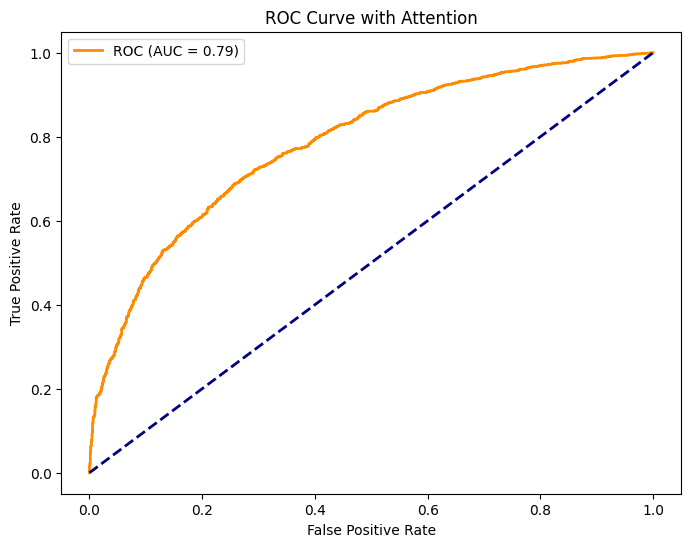

In [6]:
# Evaluation and Visualization
validation_generator.reset()
y_true = validation_generator.classes
y_pred_probs = model.predict(validation_generator).ravel()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = roc_auc_score(y_true, y_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Attention')
plt.legend()
plt.savefig('roc_attention.png')
plt.show()


In [7]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, (y_pred_probs > 0.5).astype(int), 
      target_names=['Fake (Augmented)', 'Real (Original)']))


Classification Report:
                  precision    recall  f1-score   support

Fake (Augmented)       0.73      0.79      0.76      2000
 Real (Original)       0.70      0.63      0.66      1552

        accuracy                           0.72      3552
       macro avg       0.72      0.71      0.71      3552
    weighted avg       0.72      0.72      0.72      3552



In [8]:
# Save Final Model
model.save('vggnet_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


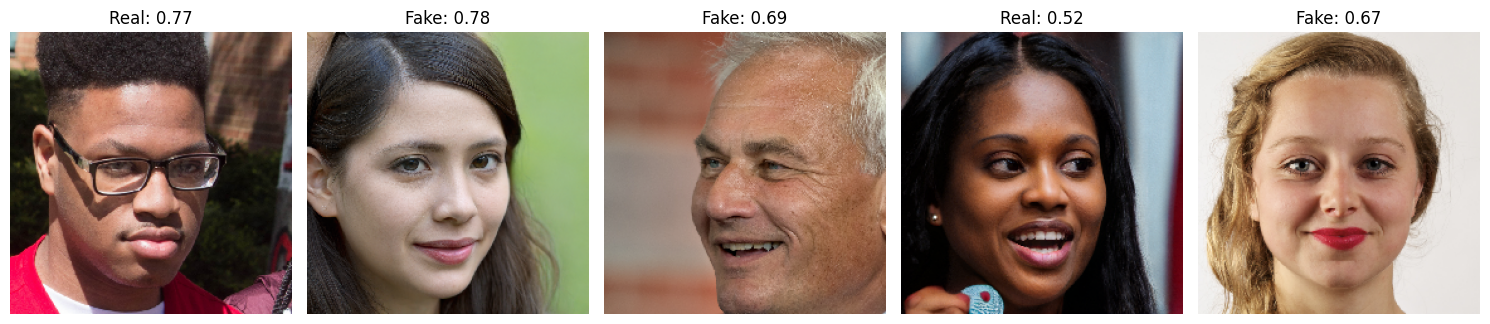

In [9]:
# Test on Sample Images
def predict_sample_images(image_paths):
    plt.figure(figsize=(15, 8))
    for i, path in enumerate(image_paths[:5]):
        img = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_preprocessed = vgg_preprocess(img_array)
        prediction = model.predict(np.expand_dims(img_preprocessed, axis=0))[0][0]
        
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f'Real: {prediction:.2f}' if prediction > 0.5 else f'Fake: {1-prediction:.2f}')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('sample_predictions.png')
    plt.show()

# Example Usage (Replace with your image paths)
sample_images = [
    '/kaggle/input/neural-network-stylegan-real-fake-dataset/output/original/orig_00018.png',
    '/kaggle/input/neural-network-stylegan-real-fake-dataset/output/augmented/aug_00008.png',
    '/kaggle/input/neural-network-stylegan-real-fake-dataset/output/original/orig_00029.png', 
    '/kaggle/input/neural-network-stylegan-real-fake-dataset/output/augmented/aug_00016.png',
    '/kaggle/input/neural-network-stylegan-real-fake-dataset/output/original/orig_00003.png'
]
predict_sample_images(sample_images)